In [138]:
from udep2mono import polarization
from polarization import run_polarize_pipeline
import networkx as nx
import matplotlib.pyplot as plt
import binarytree as bt
from wordnet import find_relation, get_word_sets
from PIL import Image, ImageDraw
from nltk.tree import Tree
from nltk.draw import TreeWidget
from nltk.draw.util import CanvasFrame
from IPython.display import Image, display
import json
import _pickle as pickle

In [31]:
#G = Ugraph()
nounModifiers = {"det", "nummod", "amod","obl:tmod", "acl:relcl", "nmod", "case"}
verbModifiers = {"advmod", "obl"}
nounCategories = {"compound"}
verbs = {"VBZ", "VBP", "VBD"}
modified = {"NN", "JJ"}.union(verbs)
modifiers = nounModifiers.union(verbModifiers)
offFocus = {"expl"}
contents = {"nsubj","obj","cop","compound","conj", "cc", "aux"}
cont_npos = {"nsubj":'nn', "obj": 'nn', "cop": 'vbz', "verb": 'vbz'}
mark_toProp = {"+": {"hyponym","synonym"}, "-": {"hypernym","synonym"}, "=": {"synonym"}}
clause_prop = {"which", "that", "who"}
be_verbs = {"is", "am", "are", "be"}

In [4]:
#G.add_node("ok",id=1)
#G.add_node("fine")

In [184]:
#nx.draw(G, with_labels=True)
sentenceset = ["This are 2 specially cool dog food", "Animal cut fresh meat carefully every month"]
test1 = ["A lady cuts some meat", "A woman cuts some meat"]
testWhich = ["a lady who is beautiful drives a car that is old ", "A beautiful woman drives a old car"]
testAnd = ["A girl eats an pear and an orange", "A girl makes coffee and eats an apple", "A girl and a boy are carefully writing homework"]
testWith = ["A girl carries the bag with a tie", "A girl with a costume eats an apple", "A boy shocks the dog under the roof"]
testThere = ["There is a girl with a bag", "Here is the homework that I just wrote", "This is the pizza that I just ordered"]
testExtract = ["The beautiful girl eats a pretty pear", "The beautiful girl eats a beautiful pear", "The pretty girl eats a pear that has beautiful marks"]
test2 = ["A dog is eating food", "A dog is blue"] 
#det order
#add word/modifier
#"and" in connection 

In [202]:
results = run_polarize_pipeline(testExtract)[0]
print(results)

100%|██████████| 3/3 [00:00<00:00,  9.46it/s][('the↑ beautiful= girl= eats↑ a↑ pretty↑ pear↑', 'The beautiful girl eats a pretty pear', '[nsubj↑ [det= [DT the↑] [amod= [JJ beautiful=] [NN girl=]]] [obj↑ [det↑ [DT a↑] [amod↑ [JJ pretty↑] [NN pear↑]]] [VBZ eats↑]]]', [(1, 'DT'), (2, 'JJ'), (3, 'NN'), (5, 'DT'), (6, 'JJ'), (7, 'NN'), (4, 'VBZ')], <binarization.BinaryDependencyTree object at 0x000001BC25A2F0C8>), ('the↑ beautiful= girl= eats↑ a↑ beautiful↑ pear↑', 'The beautiful girl eats a beautiful pear', '[nsubj↑ [det= [DT the↑] [amod= [JJ beautiful=] [NN girl=]]] [obj↑ [det↑ [DT a↑] [amod↑ [JJ beautiful↑] [NN pear↑]]] [VBZ eats↑]]]', [(1, 'DT'), (2, 'JJ'), (3, 'NN'), (5, 'DT'), (6, 'JJ'), (7, 'NN'), (4, 'VBZ')], <binarization.BinaryDependencyTree object at 0x000001BC331CAF88>), ('the↑ pretty= girl= eats↑ a↑ pear↑ that↑ has= beautiful= marks=', 'The pretty girl eats a pear that has beautiful marks', '[nsubj↑ [det= [DT the↑] [amod= [JJ pretty=] [NN girl=]]] [obj↑ [det↑ [DT a↑] [acl:relcl

In [204]:
class Unode:
    def __init__(self,prop,word,npos, mark):
        self.nexts = dict()
        self.prop = prop
        self.isRoot = False
        self.nexts["all"] = set()
        self.word = word
        self.npos = npos
        self.mark = mark
    def add_Unode(self, node):
        #print(node.prop)
        if(self.isRoot):
            self.nexts[node.prop].add(node)
        else:
            self.nexts["all"].add(node)
    def getText(self):
        if(self.isRoot):
            output = ""
            for cont in ["nsubj", "verb","obj"]:
                for ele in self.nexts[cont]:
                    output += ele.getText()
                    output += " "
            return output.strip()
        else:
            if(self.nexts["all"] == set()):
                return self.word
            output = self.word
            for element in self.nexts["all"]:
                if(element.prop == "amod"):
                    output = " " + output
                    output =  element.getText() + output
                else:
                    output += " "
                    output +=  element.getText()
                
            return output
    def get_inText(self, index):
        connected_info = ""
        if(self.isRoot):
            for key in self.nexts.keys():
                if(key != "all"):
                    print(key)
                    for keyItem in self.nexts[key]:
                        connected_info += (key + ": " + keyItem.get_inText(index + 1) + " ")
            return "{ " + connected_info + "}"
        else:
            for node in self.nexts["all"]:
                if(node != None):
                    print("111")
                    connected_info += node.get_inText(index + 1)
            return "{ The " + str(index) + " layer" + ": " + self.word + connected_info + "}"


In [8]:
class Ugraph:
    def __init__(self, rootNode):
        self.root = rootNode
        self.root.isRoot = True
        self.root.nexts.pop("all",None)
        for main in {"nsubj", "obj", "verb"}:
            self.root.nexts[main] = set()
        self.nodes = set()
        self.contentSet = set()
    def add_node(self,node):
        self.nodes.add(node)
    def add_edge(self, node1, node2):
        if(node1.isRoot):
            self.contentSet.add(node2.word)
        node1.add_Unode(node2)
    def contains(self, word_assigned):
        return word_assigned in self.contentSet

In [9]:
def print_as_graph(tree):
    G = nx.DiGraph()
    construct_treeGraph(tree,G)
    #G.add_node("this",id=2)
    nx.draw_planar(G, with_labels=True)

In [10]:
def print_tree_simple(tree):
    if(tree == "N"):
        return bt.Node("Not a Tree")
    root = bt.Node(tree.val)
    construct_tree(tree, root)
    print(root)

In [11]:
def construct_treeGraph(tree,G):
    if(tree == "N"):
        return
    else:
        if(tree.left != "N"):
            
            G.add_node(tree.left.val,id=1)
            G.add_edge(tree.val, tree.left.val)
            construct_treeGraph(tree.left,G)
        if(tree.right != "N"):
            #print(tree.right.npos==None)
            G.add_node(tree.right.val,id=1)
            G.add_edge(tree.val, tree.right.val)
            construct_treeGraph(tree.right,G)

In [12]:
def construct_tree(tree, subtree):
    if(tree == "N"):
        return
    if(tree.left != "N"):
        subtree.left = bt.Node(tree.left.val)
        construct_tree(tree.left, subtree.left)
    if(tree.right != "N"):
        subtree.right = bt.Node(tree.right.val)
        construct_tree(tree.right, subtree.right)
    

In [13]:
def jupyter_draw_nltk_tree(tree):
    cf = CanvasFrame()
    tc = TreeWidget(cf.canvas(), tree)
    tc['node_font'] = 'arial 14 bold'
    tc['leaf_font'] = 'arial 14'
    tc['node_color'] = '#005990'
    tc['leaf_color'] = '#3F8F57'
    tc['line_color'] = '#175252'
    cf.add_widget(tc, 20, 20)
    cf.print_to_file('../data/tree_img/tree.ps')
    cf.destroy()
    os.system('magick convert ../data/tree_img/tree.ps ../data/tree_img/tree.png')
    display(Image(filename='../data/tree_img/tree.png'))

In [14]:
def visualize_tree(tree):
    btree = Tree.fromstring(tree.replace('[', '(').replace(']', ')'))
    jupyter_draw_nltk_tree(btree)

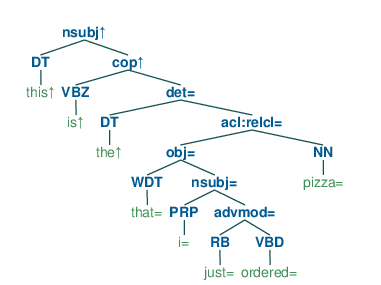

In [197]:
#print_as_graph(results[0][4])
visualize_tree(results[2][2])
#print_tree_simple(results[0][4])

In [16]:
def draw_graph():
    output = Image.new("RGB", (500, 500), (255,255,255))
    draw = ImageDraw.Draw(output)
    #draw.ellipse([100,100,200,200])
    draw.multiline_text((100, 100), "aaabbb\nword", fill=(0,0,0))
    output.show()

In [17]:
#draw_graph()

In [18]:
class graph_Info():
    def __init__(self,graph,crucials):
        self.graph = graph
        self.crucials = crucials

In [19]:
def mono2Graph(sent_info):
    G = Ugraph(Unode("root", "Root","r00t","="))
    #extract_NOV(sent_info, G)
    #print(G.root.nexts)
    #print(sent_info)
    mono2Graph_recur(sent_info, G, set()) ### root directly assigned for test here
    return G

In [20]:
def printUgraph_inText(Ugraph):
    print(Ugraph.root.get_inText(1))

In [73]:
G = mono2Graph(results[1][4])
printUgraph_inText(G)
print(len(G.nodes))
for node_p in G.nodes:
    print(node_p.word+ "222")
print(G.root.nexts.keys())

obj
111
111
111
verb
nsubj
111
{ obj: { The 2 layer: pear{ The 3 layer: a}{ The 3 layer: beautiful}{ The 3 layer: huge}} verb: { The 2 layer: eats} nsubj: { The 2 layer: girl{ The 3 layer: the}} }
7
girl222
huge222
a222
pear222
eats222
beautiful222
the222
dict_keys(['obj', 'verb', 'nsubj'])


In [27]:
# def extract_NOV(sent, G):
#     if(sent == "N"):
#         return
#     #print(sent.npos)
#     if((sent.val in contents or sent.npos in verbs) and not(sent.val in G.root.nexts.keys())):
#         print(sent.npos)
#         if sent.npos in verbs and sent.parent.val not in {"cop"}:
#             tempNode = Unode("verb", sent.val)
#         else:
#             if (sent != "N"):
#                 print(sent.val)
#             else:
#                 print(sent)
#             currentNode = sent.left
#             while(currentNode.right != "N"):
#                 currentNode = currentNode.right
#             tempNode = Unode(sent.val,currentNode.val)
#             G.add_node(tempNode)
#             G.add_edge(G.root, tempNode)
#             if(sent.val == "cop"):
#                 currentNode = sent.right
#                 while(currentNode.right != "N"):
#                     if(currentNode.val == "compound"):
#                         tempNode1 = Unode("obj",currentNode.left.val + " " + currentNode.right.val)
#                         G.add_node(tempNode1)
#                         G.add_edge(G.root, tempNode1)
#                         return
#                     currentNode = currentNode.right
#                 tempNode1 = Unode(sent.val,currentNode.val)
#                 G.add_node(tempNode1)
#                 G.add_edge(G.root, tempNode1)
        
#     #if(sent.val == "obj"):
#         #extract_NOV(sent.left, G)
#     extract_NOV(sent.right, G)

In [32]:
def mono2Graph_recur(sent_tree, G, mods, pos = None):
    needleft = True
    needright = True
    if(sent_tree == "N"):
        return
    #print(sent_tree.val)
    # 
    #if(sent_tree.nposif(sent_tree.val == "compound"):
    #         compound_out = sent_tree.left.val+" " + sent_tree.right.val
    #         G.add_node(compound_out)
    #         G.add_edge(root,compound_out)
    #         #ls.append(compound_out)
            
    #         return != None):
        #print(sent_tree.val + " " + sent_tree.parent.val)
        # if((sent_tree.npos in modified and sent_tree.npos != "JJ") or (sent_tree.parent!= "N" and sent_tree.parent.val == "nsubj")):
        #     ls.append(sent_tree.val)
        #     #G.add_node(sent_tree.val)
        #     G.add_node(sent_tree.parent.val,name=sent_tree.val)
        #     G.add_edge(root, sent_tree.parent.val)
        #     #G.add_edge(sent_tree.parent.val, sent_tree.val)
    #    print("")
    else:
        #print(sent_tree.val)
        if(sent_tree.val in modifiers):
            if(sent_tree.val == "acl:relcl"):
                G_prime = mono2Graph(sent_tree.left)
                mods.add(G_prime.root)
            else:
                left_result = mono2Graph_recur(sent_tree.left, G, set(), sent_tree.val)
                if(left_result != None):
                    mods.add(left_result)
            #print("000000000")
            #for item_print in mods:
            #    if(item_print!=None):
            #        print(item_print.word)
            #print("000000000")
            return mono2Graph_recur(sent_tree.right, G, mods, pos)            
        else:
            if ((sent_tree.left == "N" and sent_tree.right == "N") or sent_tree.val == "compound" ):
                    if(sent_tree.val == 'and'):
                        return
                    if(sent_tree.val == "compound"):
                        newNode = Unode(pos, sent_tree.left.val + " " + sent_tree.right.val,                                                        sent_tree.npos, sent_tree.mark)
                    else:
                        newNode = Unode(pos, sent_tree.val, sent_tree.npos, sent_tree.mark)
                    G.add_node(newNode)
                    if (sent_tree.npos in modified or pos in contents or pos == "verb"):
                        if(pos in contents or pos == "verb"):
                            # if(pos in G.root.nexts.keys()):
                            #     print(G.root.nexts.keys())
                            #     print(pos)
                            #     print("Error occured in concentrating contents")
                            # else:
                                G.add_edge(G.root,newNode)
                        for node in mods:
                            #if(G.contains(sent_tree.val)):
                                # loc = ""
                                # if(sent_tree.npos in verbs):
                                #     loc = "verb"
                                # else:
                                #     for key_cont in G.root.nexts.keys():
                                #         if(key_cont != "all"):
                                #             if(G.root.nexts[key_cont].word == sent_tree.val):
                                #                 loc = key_cont
                                #                 break
                                G.add_edge(newNode, node)
                        return newNode
                    else:
                        mods.add(newNode)
                        return newNode
            else: 
                if(sent_tree.val in contents):
                    pos_left = sent_tree.val
                    pos_right = pos
                    if(sent_tree.val == "nsubj"):
                        pos_right = "verb"
                    if(sent_tree.val == "cop"):
                        pos_left = "verb"
                        pos_right = "obj"
                    if(sent_tree.val == 'conj'):
                        mono2Graph_recur(sent_tree.left, G, set(), pos)
                        mono2Graph_recur(sent_tree.right, G, mods, pos)
                    elif(sent_tree.val == "aux"):
                        mono2Graph_recur(sent_tree.right, G, mods, "verb")
                    else:
                        mono2Graph_recur(sent_tree.left, G,set(),pos_left)
                        mono2Graph_recur(sent_tree.right, G, mods, pos_right)
                elif(sent_tree.val in offFocus):
                    mono2Graph_recur(sent_tree.right, G, mods, pos)
    #if(needleft):
    #    mono2Graph_recur(sent_tree.left, G, mods)
    #if(needright):
    #    mono2Graph_recur(sent_tree.right, G, mods)

In [160]:
#def mono2Graph_categorize(sent_tree, G, root):
    

In [161]:
# def find_nearest_belongTo(sent_tree, G, content_mark):
#     if(sent_tree == "N"):
#         print("Seems to have a parsing or binarization error")
#         return "", -2
#     if(sent_tree.npos == None):
#         if(sent_tree.val == "compound"):
#             comp_node = sent_tree.left.val + " " + sent_tree.right.val
#             if(comp_node in G.['dict'].keys()):
#                 print(comp_node)
#                 #G.nodes["C1"]['dict'].update({comp_node: content_mark})

#             return sent_tree, 2
#         return find_nearest_belongTo(sent_tree.right,G,content_mark)

#     elif (sent_tree.npos in modified or sent_tree.val in {"this", "these", "there", "that"} ):
#         if(sent_tree.parent.val in contents):
#             key = sent_tree.val
#             #print(sent_tree.val)
#             G.nodes["C1"]['dict'].update({key: sent_tree.parent.val})
#         return sent_tree, 1
#     else: 
#         print(sent_tree.val)
#         return "", -1

In [162]:
#graph_out1 = mono2Graph(results[0])
#graph_out2 = mono2Graph(results[0])
#print(graph_out2.graph.nodes['obl:tmod'])
#nx.draw(graph_out2.graph, with_labels=True,center="C1")

In [163]:
"compound" == ("a" or "compound" )

False

In [107]:
G1 = mono2Graph(results[0][4])
G2 = mono2Graph(results[1][4])
printUgraph_inText(G1)
printUgraph_inText(G2)
print(G.root.nexts.keys())

obj
111
111
verb
nsubj
111
{ obj: { The 2 layer: pear{ The 3 layer: a}{ The 3 layer: huge}} verb: { The 2 layer: eats} nsubj: { The 2 layer: girl{ The 3 layer: the}} }
obj
111
111
111
verb
nsubj
111
111
{ obj: { The 2 layer: pear{ The 3 layer: a}{ The 3 layer: beautiful}{ The 3 layer: huge}} verb: { The 2 layer: eats} nsubj: { The 2 layer: girl{ The 3 layer: the}{ The 3 layer: beautiful}} }
dict_keys(['obj', 'verb', 'nsubj'])


In [165]:
def check_alignment(graph1, graph2):
    return check_alignByRoot(graph1.root, graph2.root)

In [166]:
def check_alignByRoot(root1, root2):
    for cont in {"nsubj", "verb", "obj"}:
        if(not(check_cont(root1, root2, cont))):
            print(cont)
            return "UnAligned"
    return "Aligned"  

In [167]:
def check_cont(root1, root2, cont):
    core1 = root1.nexts[cont]
    core2 = root2.nexts[cont]
    return depth_check(core1, core2)


In [49]:
def depth_check(node1, node2):
    if(node1.isRoot and node2.isRoot):
        return check_alignByRoot(node1, node2)
    if(node1.isRoot or node2.isRoot):
        return compare_nodeGraph(node1, node2)
    if(node1.npos != node2.npos and not(node1.npos in verbs and node2.npos in verbs)): 
        #currently on lexical level of comparison
        print(1)
        return False
    # if(len(node1.nexts["all"]) != len(node2.nexts["all"])):
    #     #currently only caring about equal numebr of qualifiers
    #     print(2)
    #     return False
    if(node1.mark != node2.mark):
        #currently only caring about same mark
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(3)
        return False
    if((find_relation(node1.word, node2.word, node1.npos) not in mark_toProp[node1.mark]) and node1.word != node2.word):
        print("node with" + " " + node1.word + " " + node1.mark)
        print("node with" + " " + node2.word + " " + node2.mark)
        print(find_relation(node1.word, node2.word, node1.npos))
        print(4)
        return False
    for next1 in node1.nexts["all"]:
        corr_found = False
        for next2 in node2.nexts["all"]:
            if(next1.word == "Root"):
                print(next2.word)
            if(depth_check(next1, next2)):
                corr_found = True
                break
        if(not(corr_found)):
            print(5)
            print(next1.word)
            return False
    return True

In [173]:
file = open("../data/SICK/train.txt", "r")
lines = file.readlines()
indexStart = 0
output = []
fileOut = open("./sickEntailment.txt", "w")
fileOut1 = open("./sickContradiction.txt", "w")
for line in lines:
    if(indexStart < 1):
        indexStart = indexStart + 1
    else:
        argArr = line.split("\t")
        if(argArr[4]=="ENTAILMENT\n"):
            #output.append(learn_variation(argArr[1], argArr[2], argArr[3], argArr[4][0:len(argArr[4])-2]))
            fileOut.write(line)
        if(argArr[4] == "CONTRADICTION\n"):
            fileOut1.write(line)
print(output)
file.close
fileOut.close
fileOut1.close

[]


<function TextIOWrapper.close()>

In [169]:
def compare_nodeGraph(node, node2):
    if(node.isRoot):
        root = node
        wordNode = node2
    else:
        root = node2
        wordNode = node
    if(root.nexts["verb"].word in be_verbs):
        
        for adjs in {root.nexts["obj"]}:
            if(depth_check(wordNode, adjs)):
                return True
        return False

In [102]:
def check_branch(node1, node2, label = "all"):
    if(node1.word != node2.word or len(node1.nexts) != len(node2.nexts)):
        return False
    toRemove = set()
    for next1 in node1.nexts[label]:
        cor = False
        for next2 in node2.nexts[label]:
                if(next1.word == next2.word and check_branch(next1, next2)):
                    cor = True
                    node2.nexts[label].remove(next2)
                    break
        if(cor):
            toRemove.add(next1)
    print(list(k.word for k in toRemove))
    #print(list(k.word for k in node2.nexts[label]))
    for item in toRemove:
        node1.nexts[label].discard(item)
    #node1.nexts[label] = node1.nexts[label]-toRemove
    if(node1.nexts[label] == set() and node2.nexts[label] == set()):
        return True
    else:
        return False
                    

In [161]:
def extract_syntatic_var(node1, node2):
   if (node2 == None):
       return node1.getText(),-1
   if (node1 == None):
       return -1, node2.getText()
   if(node1.nexts["all"] == set() or node2.nexts["all"] == set()):
       return -1, -1
   return node1.getText(), node2.getText()

In [158]:
def learn_variation(sent1, sent2, score, rel):
    graph1 = mono2Graph(sent1)
    graph2 = mono2Graph(sent2)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    root1 = graph1.root
    root2 = graph2.root
    for cont in root1.nexts.keys():
        check_branch(root1, root2, cont)
        fileOut = open("./" + cont + "SyntacticVar" + ".txt", "w")
        list_ref1 = list(root1.nexts[cont])
        list_ref2 = list(root2.nexts[cont])
        size_iter = max(len(list_ref1), len(list_ref2))
        line1 = dict()
        line2 = dict()
        for i in range(size_iter):
            
            result1, result2 = extract_syntatic_var(list_ref1[i] if i < len(list_ref1) else None, list_ref2[i] if i < len(list_ref2) else None)
            if(result1 != -1):
                if(list_ref1[i].word not in line1.keys()):
                    line1[list_ref1[i].word] = set()
                line1[list_ref1[i].word].add(result1)
            if(result2 != -1):
                if(list_ref2[i].word not in line2.keys()):
                    line2[list_ref2[i].word] = set()
                line2[list_ref2[i].word].add(result2)
        print(line1,file=fileOut)
        print("\t",file=fileOut)
        print(line2,file=fileOut)
        print("\n",file=fileOut)
    printUgraph_inText(graph1)
    printUgraph_inText(graph2)
    return 2
#Problem with "and" in main cores alignment
#Problem with aligning different forms of the same word (i.e eat/eats, apple/apples, a/an)

In [171]:
# def det_branch(graph1, graph2, label = "all"):
#     for
        

In [123]:
print("s" + None + "test")

TypeError: can only concatenate str (not "NoneType") to str

In [149]:
test111 = [1,2,3]
test222 = dict()
test222["app"] = [1,5]
test222.toString()
print(test222)
#test111[4]
print(0 if 1>0 else 1)

AttributeError: 'dict' object has no attribute 'toString'

In [205]:
learn_variation(results[0][4], results[2][4], 4.0, "entailment")

obj
111
111
verb
nsubj
111
111
{ obj: { The 2 layer: pear{ The 3 layer: a}{ The 3 layer: pretty}} verb: { The 2 layer: eats} nsubj: { The 2 layer: girl{ The 3 layer: the}{ The 3 layer: beautiful}} }
obj
111
obj
111
verb
nsubj
111
verb
nsubj
111
111
{ obj: { The 2 layer: pear{ obj: { The 4 layer: marks{ The 5 layer: beautiful}} verb: { The 4 layer: has} nsubj: { The 4 layer: that} }{ The 3 layer: a}} verb: { The 2 layer: eats} nsubj: { The 2 layer: girl{ The 3 layer: pretty}{ The 3 layer: the}} }
[]
['a']
[]
[]
['eats']
[]
['the']
[]
obj
111
verb
nsubj
111
{ obj: { The 2 layer: pear{ The 3 layer: pretty}} nsubj: { The 2 layer: girl{ The 3 layer: beautiful}} }
obj
111
obj
111
verb
nsubj
verb
nsubj
111
{ obj: { The 2 layer: pear{ obj: { The 4 layer: marks{ The 5 layer: beautiful}} verb: { The 4 layer: has} nsubj: { The 4 layer: that} }} nsubj: { The 2 layer: girl{ The 3 layer: pretty}} }


2

In [44]:
test1 = Unode("root", "root", "root", "root")
testSet = set()
testSet.add(test1)
testSet.remove(test1)
testSet

set()

In [175]:
#get_word_sets("car","hypernym")

In [176]:
check_alignment(G1, G2)

AttributeError: 'set' object has no attribute 'isRoot'

In [111]:
ae = set()
def return1(i):
    return
ae.add(return1(2))
ae

{None}

In [251]:
find_relation("woman", "lady", "nn")

'hypernym'

In [252]:
find_relation("people","person",'nn')

In [253]:
if(1==0):
    t = 3
else:
    t = 5
print(t)

5


In [254]:
None == None

True